In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA - Data Wrangling

The EDA will be a continuation of the **Data Wrangling** from the Data Curation. Below are the general data cleaning steps before answering our project questions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

1. Load states_hash file to have an easy state abbreviation format 
2. Load electricty browser data and skip first 4 rows to get only headers and data

- https://gist.github.com/mshafrir/2646763#file-states_hash-json
- https://www.consumeraffairs.com/solar-energy/how-much-do-solar-panels-cost.html




In [3]:

dir = "/content/drive/MyDrive/DS4A Team 14 - Fall 2022/DATA CURATION/Data Source Copies/EIA Electricity Data Browser/data"
dirm = "/content/drive/MyDrive/DS4A Team 14 - Fall 2022/DATA CURATION/Data Source Copies/Miscellaneous"

with open(dirm + '/states_hash.json') as s:
    states_dict = json.load(s)

df_solar_panel = pd.read_csv(dirm + '/Cost of residential solar panels by state.csv')

df_net_gen_solar = pd.read_csv(dir + '/Net_generation_for_all_utility-scale_solar.csv', skiprows=4)
df_net_gen_coal = pd.read_csv(dir + '/Net_generation_for_coal.csv', skiprows=4)
df_net_gen_gas = pd.read_csv(dir + '/Net_generation_for_natural_gas.csv', skiprows=4)
df_cons_coal = pd.read_csv(dir + '/Consumption_for_electricity_generation_for_coal.csv', skiprows=4)
df_cons_gas = pd.read_csv(dir + '/Consumption_for_electricity_generation_for_natural_gas.csv', skiprows=4)
df_avg_cost_coal = pd.read_csv(dir + '/Average_cost_of_fossil_fuels_for_electricity_generation_(per_Btu)_for_coal.csv', skiprows=4)
df_avg_cost_gas = pd.read_csv(dir + '/Average_cost_of_fossil_fuels_for_electricity_generation_(per_Btu)_for_natural_gas.csv', skiprows=4)


In [4]:
df_net_gen_solar.head()

,description,units,source key,Jan 2001,Feb 2001,Mar 2001,Apr 2001,May 2001,Jun 2001,Jul 2001,...,Dec 2021,Jan 2022,Feb 2022,Mar 2022,Apr 2022,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022
0,Net generation for all utility-scale solar,thousand megawatthours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,thousand megawatthours,ELEC.GEN.SUN-US-99.M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States : all sectors,thousand megawatthours,ELEC.GEN.SUN-US-99.M,7,13,31,39,81,91,92,...,6091,8158,9312,11868,13438,15161,15953,15686,14375,13405
3,United States : electric power,NaN,ELEC.GEN.SUN-US-98.M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States : electric utility,thousand megawatthours,ELEC.GEN.SUN-US-1.M,0,0,0,0,0,0,0,...,883,1084,1199,1536,1707,1838,1820,1804,1708,1481


2. Remove columns: units and source key. 
- Units are constant within each report and source key is not needed
- Electricty generation - thousand megawatthours (1000 MWh)
- Electricty Consumption - thousand Mcf (1000 Mcf or 1 mil cubic feet) for NG, thousand tons for coal
- Average Cost for electricty generation - dollars per million btu ($/MMBTU)

In [5]:
elecfiles = [df_net_gen_solar, df_net_gen_coal, df_net_gen_gas, df_cons_coal, df_cons_gas, df_avg_cost_coal, df_avg_cost_gas]
for file in elecfiles:
    file.drop(columns = ["units", "source key"], inplace=True)
    

In [6]:
df_net_gen_solar.head()

,description,Jan 2001,Feb 2001,Mar 2001,Apr 2001,May 2001,Jun 2001,Jul 2001,Aug 2001,Sep 2001,...,Dec 2021,Jan 2022,Feb 2022,Mar 2022,Apr 2022,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022
0,Net generation for all utility-scale solar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States : all sectors,7,13,31,39,81,91,92,85,65,...,6091,8158,9312,11868,13438,15161,15953,15686,14375,13405
3,United States : electric power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States : electric utility,0,0,0,0,0,0,0,0,0,...,883,1084,1199,1536,1707,1838,1820,1804,1708,1481


3. Remove rows: 
- United States and Regions (New England, Middle Atlantic, etc.) totals. We are looking at a state by state analysis. Use the states dictionary to search for non state names. Note that not every state will be present
- More header rows for states. No data in these
- Any state's all sectors, industrial, or commercial data. We are only doing an analysis for residential areas, which will be from the electric utility and independent power producer sectors. Those values will be summed later on.

In [7]:
states = "|".join(states_dict.values())
# for file in elecfiles:
#     file = file[file["description"].str.contains(states)==True]
df_net_gen_solar = df_net_gen_solar[df_net_gen_solar["description"].str.contains(states)==True]
df_net_gen_coal = df_net_gen_coal[df_net_gen_coal["description"].str.contains(states)==True]
df_net_gen_gas = df_net_gen_gas[df_net_gen_gas["description"].str.contains(states)==True]
df_cons_coal = df_cons_coal[df_cons_coal["description"].str.contains(states)==True]
df_cons_gas = df_cons_gas[df_cons_gas["description"].str.contains(states)==True]
df_avg_cost_coal = df_avg_cost_coal[df_avg_cost_coal["description"].str.contains(states)==True]
df_avg_cost_gas = df_avg_cost_gas[df_avg_cost_gas["description"].str.contains(states)==True]

In [8]:
df_net_gen_solar["description"]

15                                   Massachusetts
16                     Massachusetts : all sectors
17                  Massachusetts : electric power
18                Massachusetts : electric utility
19     Massachusetts : independent power producers
                          ...                     
193                        Hawaii : electric power
194                      Hawaii : electric utility
195           Hawaii : independent power producers
196                        Hawaii : all commercial
197                        Hawaii : all industrial
Name: description, Length: 140, dtype: object

Definitions of power sectors (defined by EIA gloassary):
- Electric power sector:  An energy-consuming sector that consists of electricity only and combined heat and power(CHP) plants whose primary business is to sell electricity, or electricity and heat, to the public
- Electric utility:  A corporation, person, agency, authority, or other legal entity or instrumentality aligned with distribution facilities for delivery of electric energy for use primarily by the public. Included are investor-owned electric utilities, municipal and State utilities, Federal electric utilities, and rural electric cooperatives. A few entities that are tariff based and corporately aligned with companies that own distribution facilities are also included.
- Independent power producer: A corporation, person, agency, authority, or other legal entity or instrumentality that owns or operates facilities for the generation of electricity for use primarily by the public, and that is not an electric utility.

In [9]:
df_net_gen_solar = df_net_gen_solar[df_net_gen_solar["description"].str.contains("power producers|electric utility")==True]
df_net_gen_coal = df_net_gen_coal[df_net_gen_coal["description"].str.contains("power producers|electric utility")==True]
df_net_gen_gas = df_net_gen_gas[df_net_gen_gas["description"].str.contains("power producers|electric utility")==True]
df_cons_coal = df_cons_coal[df_cons_coal["description"].str.contains("power producers|electric utility")==True]
df_cons_gas = df_cons_gas[df_cons_gas["description"].str.contains("power producers|electric utility")==True]
df_avg_cost_coal = df_avg_cost_coal[df_avg_cost_coal["description"].str.contains("power producers|electric utility")==True]
df_avg_cost_gas = df_avg_cost_gas[df_avg_cost_gas["description"].str.contains("power producers|electric utility")==True]

4. Each column represents a Month-Year, which is in a very wide format. It would be better to put them in a single time column. Use pd.melt() to pivot. 

In [10]:
df_net_gen_solar = df_net_gen_solar.melt(id_vars="description", var_name="MMYY", value_name="Thousand MWh")
df_net_gen_coal = df_net_gen_coal.melt(id_vars="description", var_name="MMYY", value_name="Thousand MWh")
df_net_gen_gas = df_net_gen_gas.melt(id_vars="description", var_name="MMYY", value_name="Thousand MWh")
df_cons_coal = df_cons_coal.melt(id_vars="description", var_name="MMYY", value_name="Thousand Tons")
df_cons_gas = df_cons_gas.melt(id_vars="description", var_name="MMYY", value_name="Thousand Mcf")
df_avg_cost_coal = df_avg_cost_coal.melt(id_vars="description", var_name="MMYY", value_name="$/million BTU")
df_avg_cost_gas = df_avg_cost_gas.melt(id_vars="description", var_name="MMYY", value_name="$/million BTU")

In [11]:
df_net_gen_coal.head()

,description,MMYY,Thousand MWh
0,Connecticut : electric utility,Jan 2001,--
1,Connecticut : independent power producers,Jan 2001,328
2,Maine : electric utility,Jan 2001,--
3,Maine : independent power producers,Jan 2001,18
4,Massachusetts : electric utility,Jan 2001,93


5. Now we can replace some unavailable data. 

- "--" means data was not available at the time, and "NM" means Not Meaningful due to large relative standard error. We can't be certain that we can impute zero for these - it could be that the data was not reported or the surveyed values were not consistent and led to high RSE's. 
- We're also using this data for comparitive studies, and removing months may lead to a broken view of a state's time series. So we will impute NaN using the errors="coerce" argument in pd.to_numeric

In [12]:
df_net_gen_solar["Thousand MWh"]=pd.to_numeric(df_net_gen_solar["Thousand MWh"], errors='coerce')
df_net_gen_coal["Thousand MWh"]=pd.to_numeric(df_net_gen_coal["Thousand MWh"], errors='coerce')
df_net_gen_gas["Thousand MWh"]=pd.to_numeric(df_net_gen_gas["Thousand MWh"], errors='coerce')
df_cons_coal["Thousand Tons"]=pd.to_numeric(df_cons_coal["Thousand Tons"], errors='coerce')
df_cons_gas["Thousand Mcf"]=pd.to_numeric(df_cons_gas["Thousand Mcf"], errors='coerce')
df_avg_cost_coal["$/million BTU"]=pd.to_numeric(df_avg_cost_coal["$/million BTU"], errors='coerce')
df_avg_cost_gas["$/million BTU"]=pd.to_numeric(df_avg_cost_gas["$/million BTU"], errors='coerce')

In [13]:
df_net_gen_solar.head()

,description,MMYY,Thousand MWh
0,Massachusetts : electric utility,Jan 2001,NaN
1,Massachusetts : independent power producers,Jan 2001,NaN
2,Vermont : electric utility,Jan 2001,NaN
3,Vermont : independent power producers,Jan 2001,NaN
4,New Jersey : electric utility,Jan 2001,NaN


6. Split up the description column into "state" and "sector" using .split(:). Then drop description.

In [14]:
df_net_gen_solar[["State","Sector"]] = df_net_gen_solar["description"].str.split(" : ", expand=True)
df_net_gen_solar.drop(columns=["description"], inplace=True)

df_net_gen_coal[["State","Sector"]] = df_net_gen_coal["description"].str.split(" : ", expand=True)
df_net_gen_coal.drop(columns=["description"], inplace=True)

df_net_gen_gas[["State","Sector"]] = df_net_gen_gas["description"].str.split(" : ", expand=True)
df_net_gen_gas.drop(columns=["description"], inplace=True)

df_cons_coal[["State","Sector"]] = df_cons_coal["description"].str.split(" : ", expand=True)
df_cons_coal.drop(columns=["description"], inplace=True)

df_cons_gas[["State","Sector"]] = df_cons_gas["description"].str.split(" : ", expand=True)
df_cons_gas.drop(columns=["description"], inplace=True)

df_avg_cost_coal[["State","Sector"]] = df_avg_cost_coal["description"].str.split(" : ", expand=True)
df_avg_cost_coal.drop(columns=["description"], inplace=True)

df_avg_cost_gas[["State","Sector"]] = df_avg_cost_gas["description"].str.split(" : ", expand=True)
df_avg_cost_gas.drop(columns=["description"], inplace=True)

In [15]:
df_net_gen_solar.head()

,MMYY,Thousand MWh,State,Sector
0,Jan 2001,NaN,Massachusetts,electric utility
1,Jan 2001,NaN,Massachusetts,independent power producers
2,Jan 2001,NaN,Vermont,electric utility
3,Jan 2001,NaN,Vermont,independent power producers
4,Jan 2001,NaN,New Jersey,electric utility


7. Clean up the other columns and rearrange
- Convert MMYY to datetime
- Rearrange to State, Sector, MMYY, Value

In [16]:
df_net_gen_solar["MMYY"] = pd.to_datetime(df_net_gen_solar["MMYY"], format="%b%Y", errors="ignore")
df_net_gen_solar = df_net_gen_solar[["State", "Sector", "MMYY", "Thousand MWh"]]

df_net_gen_coal["MMYY"] = pd.to_datetime(df_net_gen_coal["MMYY"], format="%b%Y", errors="ignore")
df_net_gen_coal = df_net_gen_coal[["State", "Sector", "MMYY", "Thousand MWh"]]

df_net_gen_gas["MMYY"] = pd.to_datetime(df_net_gen_gas["MMYY"], format="%b%Y", errors="ignore")
df_net_gen_gas = df_net_gen_gas[["State", "Sector", "MMYY", "Thousand MWh"]]

df_cons_coal["MMYY"] = pd.to_datetime(df_cons_coal["MMYY"], format="%b%Y", errors="ignore")
df_cons_coal = df_cons_coal[["State", "Sector", "MMYY", "Thousand Tons"]]

df_cons_gas["MMYY"] = pd.to_datetime(df_cons_gas["MMYY"], format="%b%Y", errors="ignore")
df_cons_gas = df_cons_gas[["State", "Sector", "MMYY", "Thousand Mcf"]]

df_avg_cost_coal["MMYY"] = pd.to_datetime(df_avg_cost_coal["MMYY"], format="%b%Y", errors="ignore")
df_avg_cost_coal = df_avg_cost_coal[["State", "Sector", "MMYY", "$/million BTU"]]

df_avg_cost_gas["MMYY"] = pd.to_datetime(df_avg_cost_gas["MMYY"], format="%b%Y", errors="ignore")
df_avg_cost_gas = df_avg_cost_gas[["State", "Sector", "MMYY", "$/million BTU"]]

In [17]:
df_cons_gas.dtypes

State            object
Sector           object
MMYY             object
Thousand Mcf    float64
dtype: object

## **How does the generation of solar energy compare to coal and natural gas over the years and across the states?**

We want to plot and compare the net generation values for solar, coal, and natural gas. Now that the data is in the same format and columns, let's first combine the dataframes to make further analysis easier. Add another column for identification and use .concat()

In [18]:
df_net_gen_solar.loc[:,"Energy Source"] = "Solar"
df_net_gen_coal.loc[:,"Energy Source"] = "Coal"
df_net_gen_gas.loc[:,"Energy Source"] = "Natural Gas"


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [19]:
df_net_gen = pd.concat([df_net_gen_solar, df_net_gen_coal, df_net_gen_gas], ignore_index=True)

df_net_gen.head()

,State,Sector,MMYY,Thousand MWh,Energy Source
0,Massachusetts,electric utility,Jan 2001,NaN,Solar
1,Massachusetts,independent power producers,Jan 2001,NaN,Solar
2,Vermont,electric utility,Jan 2001,NaN,Solar
3,Vermont,independent power producers,Jan 2001,NaN,Solar
4,New Jersey,electric utility,Jan 2001,NaN,Solar


Let's check the data types:

In [20]:
df_net_gen.dtypes

State             object
Sector            object
MMYY              object
Thousand MWh     float64
Energy Source     object
dtype: object

Count # of NaN values in each column. Looks like only the Thousand MWh column has NaN's, which is expected from the previous "--" and "NM" values.

In [21]:
df_net_gen.isna().sum()

State                0
Sector               0
MMYY                 0
Thousand MWh     16089
Energy Source        0
dtype: int64

Count # of NaN values by Energy Source:

In [22]:
df_net_gen["Thousand MWh"].isna().groupby(df_net_gen["Energy Source"]).sum()

Energy Source
Coal           7941
Natural Gas    3293
Solar          4855
Name: Thousand MWh, dtype: int64

Count # of NaN values by State:

In [23]:
df_net_gen["Thousand MWh"].isna().groupby(df_net_gen["State"]).sum()

State
Alabama                   36
Alaska                   261
Arizona                  357
Arkansas                 123
California               261
Colorado                 291
Connecticut              333
Delaware                 505
District Of Columbia     997
Florida                  253
Georgia                  260
Hawaii                   963
Idaho                    536
Illinois                 265
Indiana                    0
Iowa                     254
Kansas                   522
Kentucky                 159
Louisiana                  1
Maine                    522
Maryland                 517
Massachusetts            468
Michigan                   0
Minnesota                172
Mississippi               12
Missouri                 136
Montana                    6
Nebraska                 425
Nevada                   334
New Hampshire            273
New Jersey               237
New Mexico               510
New York                 391
North Carolina           192
North Da

Here's some basic statistics about the Thousand Mwh column by Energy Source. On average, coal and natural gas are at least ten times more generated than solar energy in total, but has been generated for twice as much time (count column).

In [24]:
df_net_gen.groupby("Energy Source")["Thousand MWh"].describe()

,count,mean,std,min,25%,50%,75%,max
Energy Source,,,,,,,,
Coal,18681.0,1805.443178,2237.967328,-6.0,77.0,833.0,2789.0,12993.0
Natural Gas,23329.0,944.381242,1923.226847,-2.0,35.0,298.0,983.0,20179.0
Solar,5585.0,92.619517,341.083916,0.0,1.0,5.0,41.0,4364.0


We're interested in the total generation by the electric utility and independent power producer sectors. Use groupby to sum the numbers and remove the sector column.

In [25]:
df_net_gen = df_net_gen.groupby(["State","MMYY","Energy Source"]).sum(["Thousand MWh"]).reset_index()
df_net_gen.head()

,State,MMYY,Energy Source,Thousand MWh
0,Alabama,Apr 2001,Coal,4586.0
1,Alabama,Apr 2001,Natural Gas,399.0
2,Alabama,Apr 2002,Coal,4856.0
3,Alabama,Apr 2002,Natural Gas,874.0
4,Alabama,Apr 2003,Coal,5047.0


It may be helpful to add a Year column to look at a more aggregate view of the total net generation over time.


In [26]:
df_net_gen.loc[:,"YY"] = pd.to_datetime(df_net_gen["MMYY"]).dt.to_period("Y")
df_net_gen.head()

,State,MMYY,Energy Source,Thousand MWh,YY
0,Alabama,Apr 2001,Coal,4586.0,2001
1,Alabama,Apr 2001,Natural Gas,399.0,2001
2,Alabama,Apr 2002,Coal,4856.0,2002
3,Alabama,Apr 2002,Natural Gas,874.0,2002
4,Alabama,Apr 2003,Coal,5047.0,2003


We also want to use a complete data view of years, so remove 2022.

In [27]:
df_net_gen = df_net_gen[df_net_gen["YY"] < "2022"]
df_net_gen

,State,MMYY,Energy Source,Thousand MWh,YY
0,Alabama,Apr 2001,Coal,4586.0,2001
1,Alabama,Apr 2001,Natural Gas,399.0,2001
2,Alabama,Apr 2002,Coal,4856.0,2002
3,Alabama,Apr 2002,Natural Gas,874.0,2002
4,Alabama,Apr 2003,Coal,5047.0,2003
...,...,...,...,...,...
31835,Wyoming,Sep 2019,Natural Gas,29.0,2019
31836,Wyoming,Sep 2020,Coal,2644.0,2020
31837,Wyoming,Sep 2020,Natural Gas,56.0,2020
31838,Wyoming,Sep 2021,Coal,3041.0,2021


Let's pivot the data by year to plot the three sources together.

In [28]:
genpivot = df_net_gen.pivot_table(values="Thousand MWh", index="YY", columns="Energy Source", aggfunc=np.sum)
genpivot

Energy Source,Coal,Natural Gas,Solar
YY,,,
2001,1882824.0,554935.0,539.0
2002,1910612.0,607672.0,550.0
2003,1952705.0,567291.0,532.0
2004,1957193.0,627175.0,570.0
2005,1992053.0,683816.0,549.0
2006,1969719.0,734417.0,507.0
2007,1998384.0,814745.0,610.0
2008,1968844.0,802375.0,859.0
2009,1741138.0,840993.0,883.0


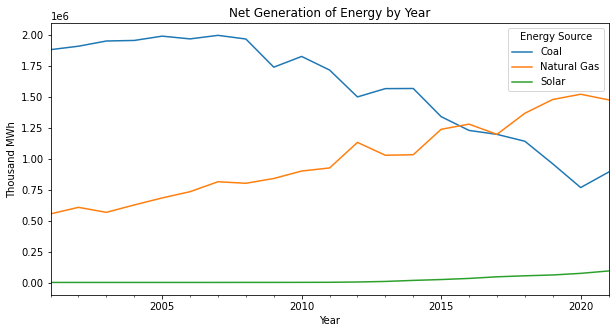

In [29]:
genpivot.plot(title="Net Generation of Energy by Year", xlabel="Year", ylabel="Thousand MWh", figsize=(10,5))

Generation of natural gas and solar energy has risen over the years while coal has decreased. But there's still a large gap between solar and its counterparts. You don't see a noticeable increase until around 2012.

As of 2021, the total natural gas generation for the country is around 150K Thousand MWh. Following the current trend, how long would it take solar generation to reach the level? We can extrapolate values from our current data

In [30]:
#scipy?

Let's compare the states that have solar generation data, and filter for after 2012. 

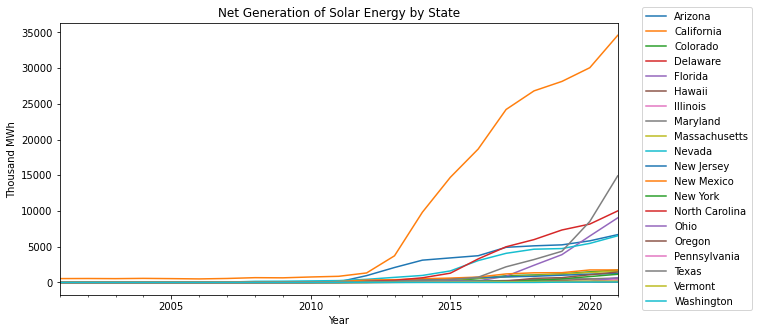

In [31]:
genstatepivot = df_net_gen[(df_net_gen['Energy Source']=="Solar")].pivot_table(values="Thousand MWh", index="YY", columns="State", aggfunc=np.sum)
genstatepivot.plot(title="Net Generation of Solar Energy by State", xlabel="Year", ylabel="Thousand MWh", figsize=(10,5))
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='right')

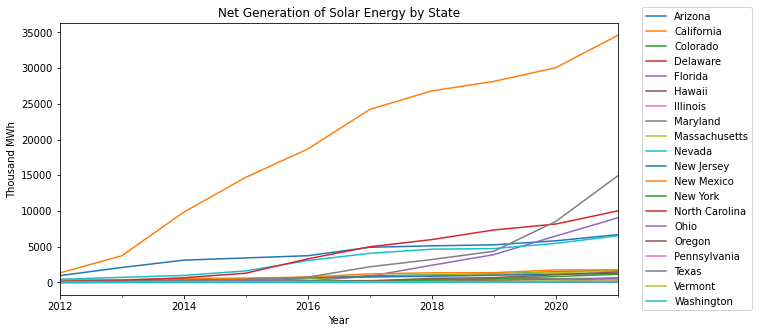

In [32]:
genstatepivot = df_net_gen[(df_net_gen['Energy Source']=="Solar") & (df_net_gen['YY']>="2012")].pivot_table(values="Thousand MWh", index="YY", columns="State", aggfunc=np.sum)
genstatepivot.plot(title="Net Generation of Solar Energy by State", xlabel="Year", ylabel="Thousand MWh", figsize=(10,5))
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='right')

We can see that California has had the highest production of solar energy by a large gap. And only 20 states have reported solar generation data.

## How has consumption of coal and natural gas for electricty generation trended through the years? How much solar energy do states need to generate to meet that demand?

Coal (thousand tons) and natural gas (thousand mcf) are in different units than the generation data, which is in MWh. These are not necessarily comparable, so we used EIA's avg conversion from 2021. These amounts can vary considerably in locations but we'll use an average for simple analysis. https://www.eia.gov/tools/faqs/faq.php?id=667&t=2


*  Coal–1.12 pounds/kWh 
* Natural gas–7.36 cubic feet/kWh
* 1 MWh = 1000 KWh
* 1 ton = 2000 pounds
* 1 MCF = 1000 cubic feet



In [33]:
df_cons_coal.loc[:,"Thousand MWh"] = df_cons_coal["Thousand Tons"]*2000*(1/1.12)*(1/1000)
df_cons_gas.loc[:,"Thousand MWh"] = df_cons_gas["Thousand Mcf"]*1000*(1/7.36)*(1/1000)


In [34]:
df_cons_coal.head()

,State,Sector,MMYY,Thousand Tons,Thousand MWh
0,Connecticut,electric utility,Jan 2001,NaN,NaN
1,Connecticut,independent power producers,Jan 2001,130.0,232.142857
2,Maine,electric utility,Jan 2001,NaN,NaN
3,Maine,independent power producers,Jan 2001,4.0,7.142857
4,Massachusetts,electric utility,Jan 2001,38.0,67.857143


In [35]:
df_cons_gas.head()

,State,Sector,MMYY,Thousand Mcf,Thousand MWh
0,Connecticut,electric utility,Jan 2001,0.0,0.000000
1,Connecticut,independent power producers,Jan 2001,892.0,121.195652
2,Maine,electric utility,Jan 2001,NaN,NaN
3,Maine,independent power producers,Jan 2001,3772.0,512.500000
4,Massachusetts,electric utility,Jan 2001,22.0,2.989130


Like before, add the Energy Source columns and combine into one dataframe. Remove the old unit columns.

In [36]:
df_cons_coal.loc[:,"Energy Source"] = "Coal"
df_cons_gas.loc[:,"Energy Source"] = "Natural Gas"
# df_avg_cost_coal.loc[:,"Energy Source"] = "Coal"
# df_avg_cost_gas.loc[:,"Energy Source"] = "Natural Gas"

In [37]:
df_cons = pd.concat([df_cons_coal, df_cons_gas], ignore_index=True)
df_cons.drop(columns=["Thousand Tons","Thousand Mcf"], inplace=True)

In [38]:
df_cons.head()

,State,Sector,MMYY,Thousand MWh,Energy Source
0,Connecticut,electric utility,Jan 2001,NaN,Coal
1,Connecticut,independent power producers,Jan 2001,232.142857,Coal
2,Maine,electric utility,Jan 2001,NaN,Coal
3,Maine,independent power producers,Jan 2001,7.142857,Coal
4,Massachusetts,electric utility,Jan 2001,67.857143,Coal


Check dtypes and Null values

In [39]:
df_cons.dtypes

State             object
Sector            object
MMYY              object
Thousand MWh     float64
Energy Source     object
dtype: object

In [40]:
df_cons.isna().sum()

State                0
Sector               0
MMYY                 0
Thousand MWh     11243
Energy Source        0
dtype: int64

In [41]:
df_cons["Thousand MWh"].isna().groupby(df_cons["Energy Source"]).sum()

Energy Source
Coal           7944
Natural Gas    3299
Name: Thousand MWh, dtype: int64

In [42]:
df_cons["Thousand MWh"].isna().groupby(df_cons["State"]).sum()

State
Alabama                  36
Alaska                  264
Arizona                 261
Arkansas                123
California              261
Colorado                 16
Connecticut             333
Delaware                249
District Of Columbia    997
Florida                  40
Georgia                 260
Hawaii                  716
Idaho                   537
Illinois                  0
Indiana                   0
Iowa                    265
Kansas                  522
Kentucky                159
Louisiana                 1
Maine                   522
Maryland                267
Massachusetts           239
Michigan                  0
Minnesota               172
Mississippi              12
Missouri                136
Montana                   4
Nebraska                423
Nevada                   84
New Hampshire           273
New Jersey               45
New Mexico              261
New York                  0
North Carolina            0
North Dakota            523
Ohio          

Basic statistics

In [43]:
df_cons.groupby("Energy Source")["Thousand MWh"].describe()

,count,mean,std,min,25%,50%,75%,max
Energy Source,,,,,,,,
Coal,18678.0,1718.614527,2120.706987,0.0,78.571429,798.214286,2769.196429,16228.571429
Natural Gas,23323.0,992.151373,1967.622795,0.0,46.059783,332.201087,1035.937500,20594.021739


Sum total the electric utility and independent power producers. Then add a year column "YY" and filter out 2022

In [44]:
df_cons = df_cons.groupby(["State","MMYY","Energy Source"]).sum(["Thousand MWh"]).reset_index()
df_cons.loc[:,"YY"] = pd.to_datetime(df_cons["MMYY"]).dt.to_period("Y")
df_cons = df_cons[df_cons["YY"] < "2022"]
df_cons

,State,MMYY,Energy Source,Thousand MWh,YY
0,Alabama,Apr 2001,Coal,3867.857143,2001
1,Alabama,Apr 2001,Natural Gas,454.076087,2001
2,Alabama,Apr 2002,Coal,4058.928571,2002
3,Alabama,Apr 2002,Natural Gas,980.570652,2002
4,Alabama,Apr 2003,Coal,4275.000000,2003
...,...,...,...,...,...
26615,Wyoming,Sep 2019,Natural Gas,30.570652,2019
26616,Wyoming,Sep 2020,Coal,2966.071429,2020
26617,Wyoming,Sep 2020,Natural Gas,73.505435,2020
26618,Wyoming,Sep 2021,Coal,3391.071429,2021


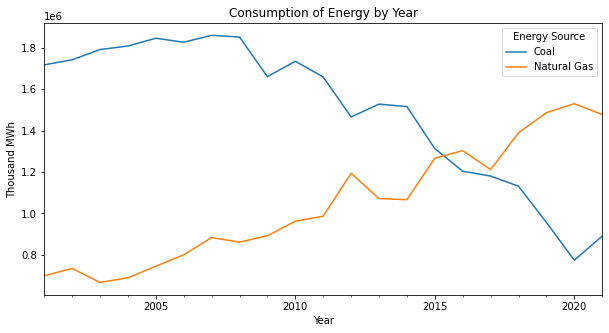

In [45]:
conspivot = df_cons.pivot_table(values="Thousand MWh", index="YY", columns="Energy Source", aggfunc=np.sum)
conspivot.plot(title="Consumption of Energy by Year", xlabel="Year", ylabel="Thousand MWh", figsize=(10,5))

Looks like they follow the same trend as their generation - coal consumption has declined while natural gas has risen. What does it look like at the state view? Let's look at coal first.

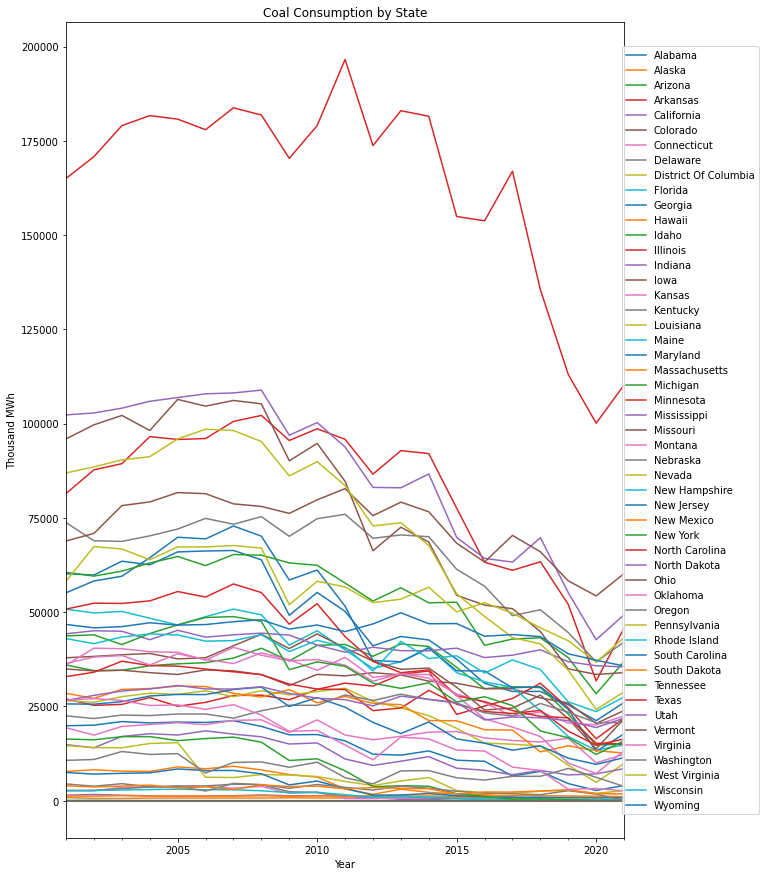

In [46]:
conscoalpivot = df_cons[(df_cons['Energy Source']=="Coal")].pivot_table(values="Thousand MWh", index="YY", columns="State", aggfunc=np.sum)
conscoalpivot.plot(title="Coal Consumption by State", xlabel="Year", ylabel="Thousand MWh", figsize=(10,15))
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='right')

There are too many states to plot on one graph, so let's see who still consumes over 50,000 Thousand MWh.

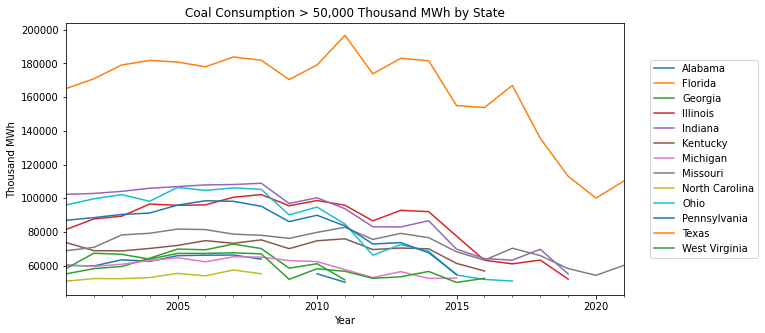

In [47]:
conscoalpivot[conscoalpivot>50000].dropna(axis=1,how="all").plot(title="Coal Consumption > 50,000 Thousand MWh by State", xlabel="Year", ylabel="Thousand MWh", figsize=(10,5), label='_nolegend_')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='right')

Here we see Texas is the largest consumer of coal by a large gap, and even though it's steadily declining, coal consumption is still around 100,000 Thousand MWh in 2021.

What does the trend look like for natural gas?

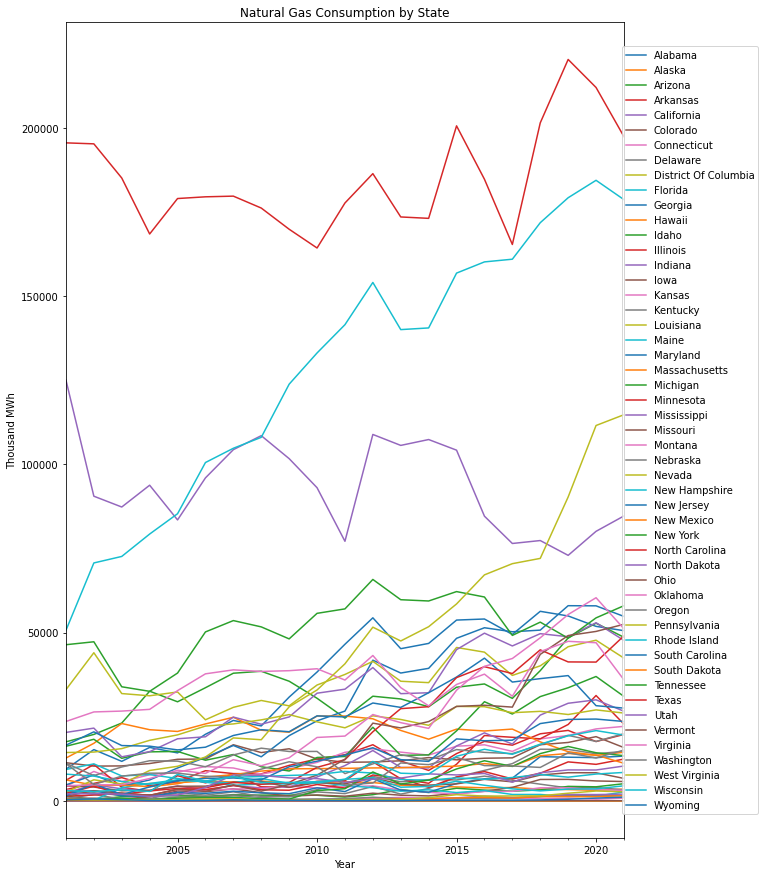

In [48]:
consgaspivot = df_cons[(df_cons['Energy Source']=="Natural Gas")].pivot_table(values="Thousand MWh", index="YY", columns="State", aggfunc=np.sum)
consgaspivot.plot(title="Natural Gas Consumption by State", xlabel="Year", ylabel="Thousand MWh", figsize=(10,15))
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='right')

Zoom in to states consuming over 50,000 Thousand MWh.

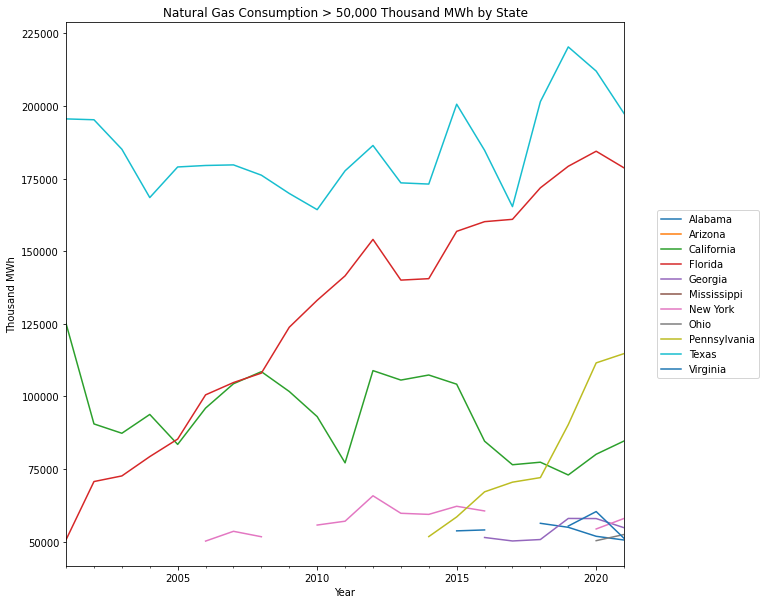

In [49]:
consgaspivot[consgaspivot>50000].dropna(axis=1,how="all").plot(title="Natural Gas Consumption > 50,000 Thousand MWh by State", xlabel="Year", ylabel="Thousand MWh", figsize=(10,10))
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='right')

Texas is still the largest consumer followed closely by Florida and California.

## Compared to the cost of coal and NG, is the ROI of solar panels worth it to the average American when considering the high installation costs? What states are gving the best incentives and tax breaks?

We have avg costs of coal and natural gas from EIA. Since solar panels are usually comission based, we'll use another source to get an estimate of installation costs and the state tax credits. Please note multiple factors come into play such as type of panel, system size, and % sunshine, but we will go with a simple dollar/watt estimate.

Let's clean up the column names from the solar panel data first - they're a bit cumbersome. We also want to just use the 2021 federal tax credit.

In [50]:
df_solar_panel.head()

,State,Starting cost for 6-kW system*,Average cost per watt**,2020 federal tax credit value (26%),2021 federal tax credit value (22%
0,Alabama,"$13,706.00",$2.45,"$3,564.00","$3,015.00"
1,Alaska,"$13,454.00",$2.41,"$3,498.00","$2,960.00"
2,Arizona,"$13,680.00",$2.67,"$3,557.00","$3,010.00"
3,Arkansas,"$14,713.00",$2.63,"$3,825.00","$3,237.00"
4,California,"$15,240.00",$2.68,"$3,962.00","$3,353.00"


In [51]:
df_solar_panel.rename(columns = {"Starting cost for 6-kW system*":"Starting Cost",
                                 "Average cost per watt**":"Avg Cost/Watt",
                                 "2021 federal tax credit value (22%":"2021 Tax Credit"}, inplace = True)
df_solar_panel.drop(columns = "2020 federal tax credit value (26%)", inplace=True)
df_solar_panel.head()

,State,Starting Cost,Avg Cost/Watt,2021 Tax Credit
0,Alabama,"$13,706.00",$2.45,"$3,015.00"
1,Alaska,"$13,454.00",$2.41,"$2,960.00"
2,Arizona,"$13,680.00",$2.67,"$3,010.00"
3,Arkansas,"$14,713.00",$2.63,"$3,237.00"
4,California,"$15,240.00",$2.68,"$3,353.00"


In [52]:
df_solar_panel.dtypes

State              object
Starting Cost      object
Avg Cost/Watt      object
2021 Tax Credit    object
dtype: object

Remove dollar signs, commas and convert to floats

In [53]:
df_solar_panel["Starting Cost"] = df_solar_panel["Starting Cost"].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)
df_solar_panel["2021 Tax Credit"] = df_solar_panel["2021 Tax Credit"].str.replace("$","",regex=True).str.replace(",","",regex=True).astype(float)
df_solar_panel["Avg Cost/Watt"] = df_solar_panel["Avg Cost/Watt"].str.replace("$","",regex=True).astype(float)
df_solar_panel.head()

,State,Starting Cost,Avg Cost/Watt,2021 Tax Credit
0,Alabama,13706.0,2.45,3015.0
1,Alaska,13454.0,2.41,2960.0
2,Arizona,13680.0,2.67,3010.0
3,Arkansas,14713.0,2.63,3237.0
4,California,15240.0,2.68,3353.0


In [54]:
df_solar_panel.describe()

,Starting Cost,Avg Cost/Watt,2021 Tax Credit
count,51.000000,51.000000,51.000000
mean,15335.941176,2.599608,3372.784314
std,1330.465023,0.158808,294.476234
min,13101.000000,2.330000,2882.000000
25%,14380.000000,2.470000,3163.500000
50%,15300.000000,2.610000,3366.000000
75%,16136.500000,2.685000,3550.000000
max,19560.000000,2.880000,4303.000000


What's the distribution of the Avg Cost/Watt?

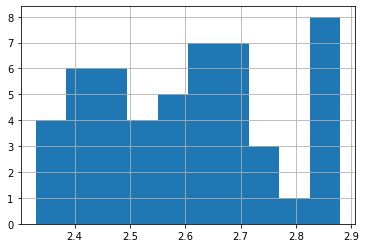

In [55]:
df_solar_panel["Avg Cost/Watt"].hist()

The distribution is slight multimodal, slighly uniform. More frequent to see avg dollar/watt prices around $2.90.

Let's combine the avg cost data from coal and natural gas, but this time only filter for 2021 data to compare with our solar energy data, and find the average cost for the year. We will convert the dollar/million BTU to dollar/Watt


*  1 Million BTU = 293,071 Watt hour
* 1 million watts = 1 MW



In [56]:
df_avg_cost_coal.loc[:,"Energy Source"] = "Coal"
df_avg_cost_gas.loc[:,"Energy Source"] = "Natural Gas"
df_avg_cost = pd.concat([df_avg_cost_coal, df_avg_cost_gas], ignore_index=True)
df_avg_cost.head()

,State,Sector,MMYY,$/million BTU,Energy Source
0,Connecticut,electric utility,Jan 2008,NaN,Coal
1,Connecticut,independent power producers,Jan 2008,NaN,Coal
2,Maine,electric utility,Jan 2008,NaN,Coal
3,Maine,independent power producers,Jan 2008,NaN,Coal
4,Massachusetts,electric utility,Jan 2008,NaN,Coal


In [57]:

df_avg_cost.loc[:,"YY"] = pd.to_datetime(df_avg_cost["MMYY"]).dt.to_period("Y")
df_avg_cost = df_avg_cost[df_avg_cost["YY"] == "2021"]
df_avg_cost = df_avg_cost.groupby(["State","Energy Source"]).mean(["$/million BTU"]).reset_index()
df_avg_cost.loc[:,"Avg Cost/Watt"] = df_avg_cost["$/million BTU"]/293071
df_avg_cost.drop(columns="$/million BTU",inplace=True)
#consgaspivot = df_cons[(df_cons['Energy Source']=="Natural Gas")].pivot_table(values="Thousand MWh", index="YY", columns="State", aggfunc=np.sum)
df_avg_cost.head()

,State,Energy Source,Avg Cost/Watt
0,Alabama,Coal,0.000007
1,Alabama,Natural Gas,0.000015
2,Alaska,Coal,0.000006
3,Alaska,Natural Gas,0.000021
4,Arizona,Coal,0.000008


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fda474a76a0>,
      dtype=object)

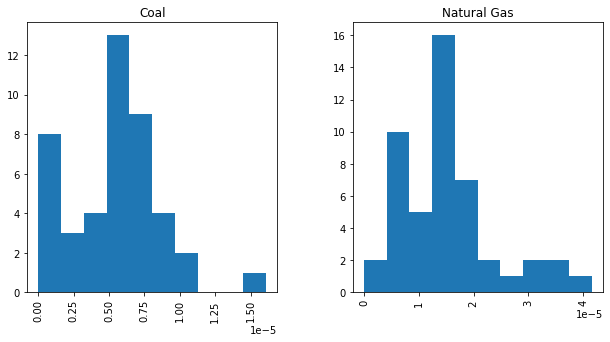

In [58]:
df_avg_cost.hist(by = "Energy Source", figsize=(10,5))

The distributions of avg costs are slightly skewed left for both coal and natural gas

Let's combine our solar data back with the others, and impute 0 for the tax credit and starting cost columns for coal and natural gas.

In [59]:
df_solar_panel.loc[:,"Energy Source"]="Solar"
df_cost = pd.concat([df_solar_panel, df_avg_cost], ignore_index=True)

In [60]:
df_cost.fillna(0)

,State,Starting Cost,Avg Cost/Watt,2021 Tax Credit,Energy Source
0,Alabama,13706.0,2.450000,3015.0,Solar
1,Alaska,13454.0,2.410000,2960.0,Solar
2,Arizona,13680.0,2.670000,3010.0,Solar
3,Arkansas,14713.0,2.630000,3237.0,Solar
4,California,15240.0,2.680000,3353.0,Solar
...,...,...,...,...,...
148,West Virginia,0.0,0.000014,0.0,Natural Gas
149,Wisconsin,0.0,0.000007,0.0,Coal
150,Wisconsin,0.0,0.000006,0.0,Natural Gas
151,Wyoming,0.0,0.000005,0.0,Coal


In [61]:
df_cost.isna().sum()

State                0
Starting Cost      102
Avg Cost/Watt       10
2021 Tax Credit    102
Energy Source        0
dtype: int64

In [62]:
df_cost.dtypes

State               object
Starting Cost      float64
Avg Cost/Watt      float64
2021 Tax Credit    float64
Energy Source       object
dtype: object

In [63]:
df_cost.groupby("Energy Source")["Avg Cost/Watt"].describe()

,count,mean,std,min,25%,50%,75%,max
Energy Source,,,,,,,,
Coal,44.0,0.000005,0.000003,0.00,0.000003,0.000006,0.000007,0.000016
Natural Gas,48.0,0.000015,0.000009,0.00,0.000009,0.000014,0.000018,0.000042
Solar,51.0,2.599608,0.158808,2.33,2.470000,2.610000,2.685000,2.880000


It seems like the average cost per watt for solar is significantly higher than coal and natural gas, so why would residents switch to panels? The $/watt for solar is based on the one time starting costs, while coal and NG would be a continuous cost for electricty. If we subtract the federal tax credit from the starting costs, how long would it take for solar panel installations to pay off based on the current coal and NG prices?

[delete?]Note again that the solar prices are based on a 6 KW system, a common energy system for most households. So let's assume a single household is using at most 6KW electricty per month from fossil fuels, or 72KWh a year.

In [64]:
df_cost["After Credit"] = df_cost["Starting Cost"] - df_cost["2021 Tax Credit"]

In [65]:
# dfmerge = pd.merge(df_cost.pivot_table(values="Avg Cost/Watt", index="State", columns=["Energy Source"]),df_cost[["State","After Credit"]], on="State")
# dfmerge = dfmerge.dropna()
# dfmerge.loc[:,"Coal KWh"] = dfmerge["Coal"]*72*1000
# dfmerge.loc[:,"NG KWh"] = (dfmerge["After Credit"]/(dfmerge["Natural Gas"]*1000))/72
# dfmerge

pivot the table to muliply the  fossil fuel's $/ watt by the After Credit column.

In [66]:
#df_cost.loc[:,"Fossil Fuel Cost per Year"] = df_cost["Avg Cost/Watt"]*72*1000
#df_cost.loc[:,"Fossil Fuel Cost per Year"]=df_cost["Avg Cost/Watt"]*72*1000

In [67]:
df_cost.to_csv(dir + '/Energy Source - Avg Cost per Watt per MMYY.csv')
df_cons.to_csv(dir + '/Fossil Fuels - Avg Consumption per MMYY.csv')
df_net_gen.to_csv(dir + '/Energy Source - Avg Generation per MMYY.csv')